In [9]:
import gamspy as gp
import gamspy.math as gpm
from gamspy import Sum, Card

import sys
import numpy as np
import pandas as pd

In [11]:
m = gp.Container(load_from="folioqp.gdx")

# Sets
s,risk,nam = m.getSymbols(["shares", "risk", "nam"])

# Parameters
maxval, maxr, minam, ret, var = m.getSymbols(["maxval", "maxr", "minam", "ret", "var"])

minret = m.addParameter("minret", records=10)

t = m.addAlias("t",s)

x = m.addVariable("x",
    type="positive",
    domain=s,
    description="investments")

budget = m.addEquation(name="budget")
budget[:] = Sum(s, x[s]) == 1.0

## At most 30% of capital into a single share
single_share = m.addEquation(name='single_share', domain=[s])
single_share[s] =  x[s] <= maxval

## At least 50% into north american shares
na_shares = m.addEquation(name='na_shares')
na_shares[:] = Sum(nam, x[nam]) >= (Sum(s, x[s]) / 2) 

## At most 33% into High Risk shares
risk_shares = m.addEquation(name='risk_shares')
risk_shares[:] = Sum(risk, x[risk]) <= (Sum(s, x[s]) / 3)

## Achieve a expected return of 10
retcon = m.addEquation(name="retcon", description="returns constraint")
retcon[:] = Sum(s, x[s] * ret[s]) >= minret

In [12]:
# Input model and target = 10 here
markowitz = m.addModel("markowitz",
    equations=m.getEquations(),
    problem=gp.Problem.QCP,
    sense=gp.Sense.MIN,
    objective=Sum([s,t], x[s]*var[s,t]*x[t]))

markowitz.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalLocal,0.670317169241543,15,11,QCP,IPOPTH,0.008


In [13]:
solret = []
soldev = []

expected_return = m.addParameter('expected_return')
expected_risk = m.addParameter('expected_risk')

ranges = iter(range(5, 32))
for target_return in ranges:
    minret.setRecords(target_return)
    markowitz.solve(options=gp.Options(qcp="conopt"),output=None)
    if markowitz.status in [
        gp.ModelStatus.OptimalGlobal,
        gp.ModelStatus.OptimalLocal,
    ]:

        solret.append(target_return)
        soldev.append(markowitz.objective_value)
    else:
        break

# Calculate values on Pareto curve here

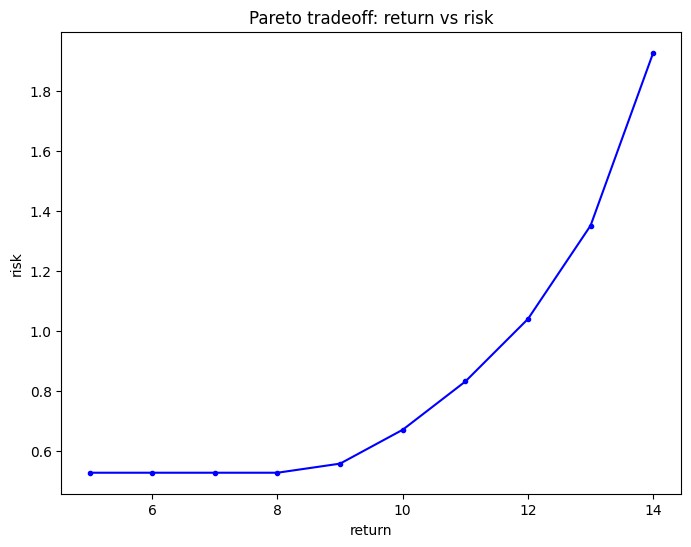

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("Pareto tradeoff: return vs risk")
ax.set_xlabel("return")
ax.set_ylabel("risk")
ax.plot(solret,soldev,"b.-");